# Install Semua Library yang dibutuhkan

In [1]:
!pip install google-generativeai
!pip install langchain-google-genai
!pip install langchain
!pip install pypdf
!pip install langchain-community
!pip install unstructured
!pip install openpyxl
!pip install docx2txt
!pip install python-magic
!pip install python-pptx
!pip install faiss-cpu
!pip install tiktoken
!pip install langgraph
!pip install wikipedia
!pip install arxiv
!pip install tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.7/309.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.6/212.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 8.8 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 s

# Import Semua Library

In [2]:
import os
from typing import TypedDict, List, Optional, Dict, Any
import json
import asyncio
from concurrent.futures import ThreadPoolExecutor
import statistics
from dataclasses import dataclass
from enum import Enum

from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END

# Define LLM dan tools

In [5]:
from google.colab import userdata
# API Keys
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
TAVILY_API_KEY = userdata.get("TAVILY_API_KEY")

# Initialize LLM and Embeddings
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    google_api_key=GOOGLE_API_KEY
)

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
    google_api_key=GOOGLE_API_KEY
)

web_search_tool = TavilySearchResults(k=3, tavily_api_key=TAVILY_API_KEY) if TAVILY_API_KEY else None

In [6]:
# Document Processing (from original code)
class DocumentProcessor:
    def __init__(self):
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
        )
        self.vectorstore = None

    def process_pdf(self, file_path: str):
        """Process PDF and create vector store"""
        loader = PyPDFLoader(file_path)
        documents = loader.load()
        splits = self.text_splitter.split_documents(documents)
        self.vectorstore = FAISS.from_documents(splits, embeddings)
        combined_text = "\n\n".join([doc.page_content for doc in documents])
        return combined_text

    def retrieve_docs(self, query: str, k: int = 3) -> List[str]:
        """Retrieve relevant documents"""
        if self.vectorstore:
            docs = self.vectorstore.similarity_search(query, k=k)
            return [doc.page_content for doc in docs]
        else:
            return []

# Initialize document processor
doc_processor = DocumentProcessor()

# CHAIN-OF-THOUGHT (CoT)

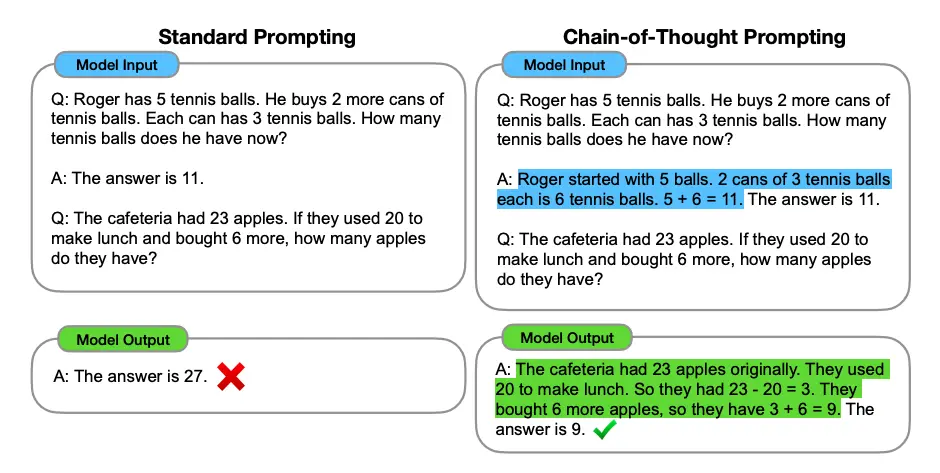

In [7]:
class CoTState(TypedDict, total=False):
    question: str
    context: str
    reasoning_steps: List[str]
    final_answer: str

COT_PROMPT = PromptTemplate.from_template("""
You are an expert assistant. Answer the question step by step, showing your reasoning process clearly.

Context:
{context}

Question: {question}

Instructions:
1. Break down the question into smaller parts
2. Analyze each part step by step
3. Show your reasoning process clearly
4. Provide a final comprehensive answer

Let's think step by step:

Step 1: [Identify key components of the question]

Step 2: [Analyze relevant information from context]

Step 3: [Apply logical reasoning]

Step 4: [Synthesize information]

Final Answer: [Provide comprehensive answer]

Response:""")

def cot_reasoning_node(state: CoTState):
    """Chain-of-Thought reasoning node"""
    question = state["question"]
    context = state["context"]

    cot_chain = LLMChain(
        llm=llm,
        prompt=COT_PROMPT,
        output_key="reasoning"
    )

    result = cot_chain.run(
        context=context,
        question=question
    )

    # Extract steps and final answer
    steps = []
    lines = result.split('\n')
    for line in lines:
        if line.strip().startswith('Step') or line.strip().startswith('Final Answer'):
            steps.append(line.strip())

    return {
        **state,
        "reasoning_steps": steps,
        "final_answer": result
    }

def create_cot_workflow():
    """Create Chain-of-Thought workflow"""
    workflow = StateGraph(CoTState)
    workflow.add_node("cot_reasoning", cot_reasoning_node)
    workflow.set_entry_point("cot_reasoning")
    workflow.add_edge("cot_reasoning", END)
    return workflow.compile()

In [9]:
def run_advanced_reasoning_methods(question: str, pdf_path: str):
    """
    Run all four advanced reasoning methods on the given question and document.

    Args:
        question: The question to answer
        pdf_path: Path to the PDF document
    """

    # Process document
    print("Processing document...")
    document_context = doc_processor.process_pdf(pdf_path)
    retrieved_docs = doc_processor.retrieve_docs(question, k=3)
    context = "\n\n".join(retrieved_docs)

    results = {}

    # 1. Chain-of-Thought
    print("\n" + "="*50)
    print("1. CHAIN-OF-THOUGHT REASONING")
    print("="*50)

    cot_workflow = create_cot_workflow()
    cot_state = {
        "question": question,
        "context": context
    }
    cot_result = cot_workflow.invoke(cot_state)
    results["cot"] = cot_result["final_answer"]
    print(cot_result["final_answer"])
    return results

question = "Explain Usaha pemanfaatan dan pemungutan di hutan lindung"
pdf_path = "ruu1.pdf"
results = run_advanced_reasoning_methods(question, pdf_path)

Processing document...

1. CHAIN-OF-THOUGHT REASONING


/tmp/ipython-input-7-1522005643.py:40: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  cot_chain = LLMChain(
/tmp/ipython-input-7-1522005643.py:46: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = cot_chain.run(


Okay, let's break down the question and analyze the provided text to understand "Usaha pemanfaatan dan pemungutan di hutan lindung" (Utilization and collection efforts in protected forests).

**Step 1: Identify key components of the question**

The question asks about:

*   "Usaha pemanfaatan" (Utilization efforts)
*   "Pemungutan" (Collection)
*   "Hutan lindung" (Protected forests)

We need to understand what kind of utilization and collection activities are allowed or relevant in the context of protected forests. The provided text doesn't directly define "hutan lindung" (protected forest), but it does discuss "hutan produksi" (production forest) and general principles of forest management.

**Step 2: Analyze relevant information from context**

The provided text focuses more on "hutan produksi" (production forest) than "hutan lindung" (protected forest). However, we can infer some principles:

*   **General Principle:** Forest management should be sustainable and environmentally con

# TREE OF THOUGHTS (TOT)

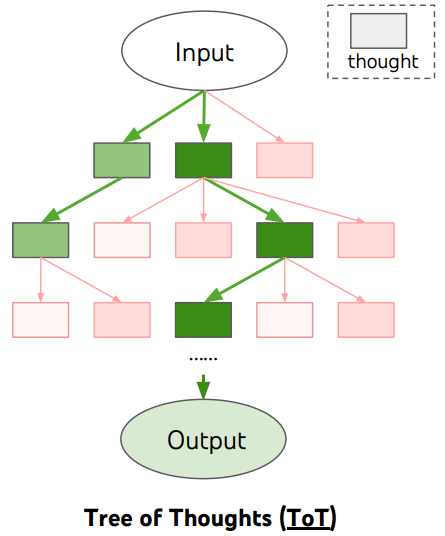

In [15]:
class ToTState(TypedDict, total=False):
    question: str
    context: str
    thought_branches: List[Dict[str, Any]]
    evaluated_branches: List[Dict[str, Any]]
    best_path: List[str]
    final_answer: str

TOT_GENERATE_PROMPT = PromptTemplate.from_template("""
Generate multiple different reasoning approaches for the following question.

Context:
{context}

Question: {question}

Generate 3 different approaches to solve this question:

Approach 1: [Brief description of first approach]
Approach 2: [Brief description of second approach]
Approach 3: [Brief description of third approach]

Approaches:""")

TOT_EVALUATE_PROMPT = PromptTemplate.from_template("""
Evaluate the following reasoning approach for answering the question.

Context:
{context}

Question: {question}

Approach: {approach}

Rate this approach on a scale of 1-10 based on:
- Relevance to the question
- Logical consistency
- Completeness
- Accuracy potential

Provide detailed reasoning for your evaluation.

Evaluation:""")

TOT_SOLVE_PROMPT = PromptTemplate.from_template("""
Using the best approach identified, solve the question step by step.

Context:
{context}

Question: {question}

Best Approach: {best_approach}

Solve this step by step using the selected approach:

Solution:""")

def tot_generate_node(state: ToTState):
    """Generate multiple reasoning approaches"""
    question = state["question"]
    context = state["context"]

    generate_chain = LLMChain(
        llm=llm,
        prompt=TOT_GENERATE_PROMPT,
        output_key="approaches"
    )

    result = generate_chain.run(
        context=context,
        question=question
    )

    print(f"Raw output from tot_generate_node:\n{result}") # Print raw output for debugging

    # Parse approaches
    approaches = []
    lines = result.split('\n')
    for line in lines:
        if line.strip().startswith('Approach'):
            approaches.append(line.strip())

    if not approaches:
        print("Warning: No approaches generated by tot_generate_node.")
        thought_branches = []
    else:
        thought_branches = [{"approach": approach, "score": 0} for approach in approaches]


    return {
        **state,
        "thought_branches": thought_branches
    }

def tot_evaluate_node(state: ToTState):
    """Evaluate each reasoning approach"""
    question = state["question"]
    context = state["context"]
    branches = state.get("thought_branches", []) # Get branches, default to empty list

    if not branches:
        print("Skipping tot_evaluate_node as no branches were generated.")
        return {
            **state,
            "evaluated_branches": []
        }

    evaluate_chain = LLMChain(
        llm=llm,
        prompt=TOT_EVALUATE_PROMPT,
        output_key="evaluation"
    )

    evaluated_branches = []
    for branch in branches:
        evaluation = evaluate_chain.run(
            context=context,
            question=question,
            approach=branch["approach"]
        )

        # Extract score (simple heuristic)
        score = 5  # default
        if "10" in evaluation or "9" in evaluation:
            score = 9
        elif "8" in evaluation or "7" in evaluation:
            score = 7
        elif "6" in evaluation or "5" in evaluation:
            score = 5
        elif "4" in evaluation or "3" in evaluation:
            score = 3

        evaluated_branches.append({
            "approach": branch["approach"],
            "score": score,
            "evaluation": evaluation
        })

    return {
        **state,
        "evaluated_branches": evaluated_branches
    }

def tot_solve_node(state: ToTState):
    """Solve using the best approach"""
    question = state["question"]
    context = state["context"]
    evaluated_branches = state.get("evaluated_branches", []) # Get evaluated_branches, default to empty list

    if not evaluated_branches:
        print("Skipping tot_solve_node as no evaluated branches are available.")
        return {
            **state,
            "best_path": [],
            "final_answer": "Could not generate a solution due to an issue in the previous steps."
        }

    # Find best approach
    best_branch = max(evaluated_branches, key=lambda x: x["score"])
    best_approach = best_branch["approach"]

    solve_chain = LLMChain(
        llm=llm,
        prompt=TOT_SOLVE_PROMPT,
        output_key="solution"
    )

    solution = solve_chain.run(
        context=context,
        question=question,
        best_approach=best_approach
    )

    return {
        **state,
        "best_path": [best_approach],
        "final_answer": solution
    }

def create_tot_workflow():
    """Create Tree of Thoughts workflow"""
    workflow = StateGraph(ToTState)
    workflow.add_node("tot_generate", tot_generate_node)
    workflow.add_node("tot_evaluate", tot_evaluate_node)
    workflow.add_node("tot_solve", tot_solve_node)

    workflow.set_entry_point("tot_generate")
    workflow.add_edge("tot_generate", "tot_evaluate")
    workflow.add_edge("tot_evaluate", "tot_solve")
    workflow.add_edge("tot_solve", END)

    return workflow.compile()

In [26]:
def run_advanced_reasoning_methods(question: str, pdf_path: str):
    """
    Run all four advanced reasoning methods on the given question and document.

    Args:
        question: The question to answer
        pdf_path: Path to the PDF document
    """

    # Process document
    print("Processing document...")
    document_context = doc_processor.process_pdf(pdf_path)
    retrieved_docs = doc_processor.retrieve_docs(question, k=3)
    context = "\n\n".join(retrieved_docs)

    results = {}

    # 2. Tree of Thoughts
    print("\n" + "="*50)
    print("2. TREE OF THOUGHTS REASONING")
    print("="*50)

    tot_workflow = create_tot_workflow()
    tot_state = {
        "question": question,
        "context": context
    }
    tot_result = tot_workflow.invoke(tot_state)
    results["tot"] = tot_result["final_answer"]
    print(tot_result["final_answer"])

question = "Explain Usaha pemanfaatan dan pemungutan di hutan lindung"
pdf_path = "ruu1.pdf"
results = run_advanced_reasoning_methods(question, pdf_path)

Processing document...

2. TREE OF THOUGHTS REASONING
Raw output from tot_generate_node:
Here are three different approaches to explain "Usaha pemanfaatan dan pemungutan di hutan lindung" (Utilization and collection activities in protected forests) based on the provided text and general knowledge of Indonesian forestry regulations:

**Approach 1: Direct Textual Analysis and Inference**

*   **Description:** This approach focuses on extracting relevant information directly from the provided text and making logical inferences based on the context. It acknowledges the limitations of the text (which doesn't directly address protected forests) and uses the information about production forests as a basis for understanding the *likely* restrictions in protected forests.

*   **Reasoning:**
    1.  **Identify Relevant Sections:** Scan the text for mentions of "pemanfaatan" (utilization), "pemungutan" (collection), "hutan" (forest), and any terms related to forest management.
    2.  **Analyze 

# REACT (REASONING + ACTING)

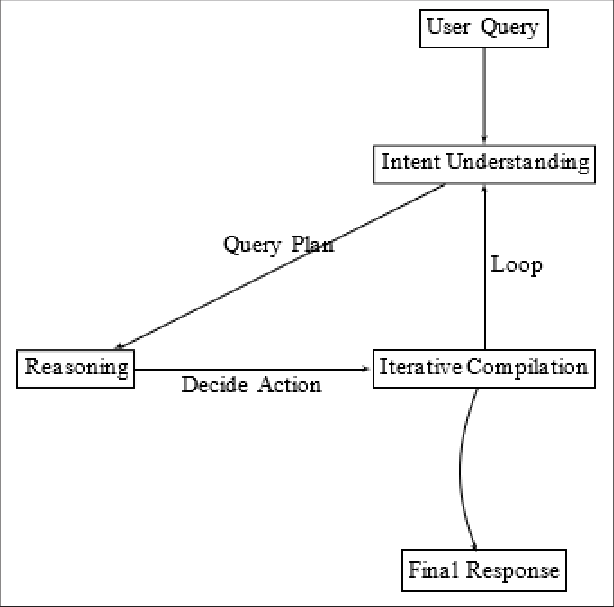

In [24]:
class ReActState(TypedDict, total=False):
    question: str
    context: str
    thought: str
    action: str
    observation: str
    reasoning_trace: List[Dict[str, str]]
    final_answer: str
    iteration: int
    max_iterations: int

# Improved ReAct prompt with better instructions
REACT_PROMPT = PromptTemplate.from_template("""
You are an expert assistant using the ReAct framework. You have access to context from a document and need to answer questions about it.

Context:
{context}

Question: {question}

Previous reasoning trace:
{reasoning_trace}

Current iteration: {iteration}/{max_iterations}

Instructions:
1. Think: Analyze what you need to do next based on the question and available context
2. Act: Choose one of these actions:
   - "search_context": Look for specific information in the provided context
   - "analyze_info": Analyze the information you've found
   - "conclude": Provide the final answer when you have sufficient information
3. Observe: Note what you learned from the action

Available context contains information about forest management regulations. Use this context to answer the question.

Format your response EXACTLY as:
Thought: [Your reasoning about what to do next]
Action: [One of: search_context, analyze_info, or conclude]
Observation: [What you observed/learned from your action]

Response:""")

def react_reasoning_node(state: ReActState):
    """ReAct reasoning node with improved logic and step-by-step display"""
    question = state["question"]
    context = state["context"]
    reasoning_trace = state.get("reasoning_trace", [])
    iteration = state.get("iteration", 0)
    max_iterations = state.get("max_iterations", 3)

    print(f"\n🔄 ReAct Iteration {iteration + 1}/{max_iterations}")
    print("-" * 60)

    # Check if we've reached max iterations
    if iteration >= max_iterations:
        print("⏹️  Maximum iterations reached. Generating final answer...")
        final_answer = generate_final_answer(question, context, reasoning_trace)
        print(f"✅ Final Answer Generated: {final_answer[:100]}...")
        return {
            **state,
            "final_answer": final_answer,
            "iteration": iteration
        }

    # Format reasoning trace for display
    trace_str = ""
    if reasoning_trace:
        trace_str = "\n".join([
            f"Step {i+1} - Thought: {step.get('thought', '')}, Action: {step.get('action', '')}, Observation: {step.get('observation', '')}"
            for i, step in enumerate(reasoning_trace)
        ])
        print(f"📝 Previous Steps Summary:\n{trace_str}\n")
    else:
        trace_str = "No previous steps"
        print("📝 This is the first iteration\n")

    # Create the chain
    react_chain = LLMChain(
        llm=llm,
        prompt=REACT_PROMPT,
        output_key="response"
    )

    try:
        print("🤖 Sending prompt to LLM...")
        result = react_chain.run(
            context=context,
            question=question,
            reasoning_trace=trace_str,
            iteration=iteration + 1,
            max_iterations=max_iterations
        )

        print(f"📤 LLM Raw Response:\n{result}\n")

        # Parse response with better error handling
        thought, action, observation = parse_react_response(result)

        print("🔍 Parsed Components:")
        print(f"   💭 Thought: {thought}")
        print(f"   🎯 Action: {action}")
        print(f"   👀 Initial Observation: {observation}")

        # Process the action
        print(f"\n⚡ Processing Action: {action}")
        if action == "search_context":
            observation = search_context_for_info(context, question, thought)
            print(f"🔍 Search Result: {observation}")
        elif action == "analyze_info":
            observation = analyze_available_info(context, question, reasoning_trace)
            print(f"📊 Analysis Result: {observation}")
        elif action == "conclude":
            print("🎯 Concluding and generating final answer...")
            final_answer = generate_final_answer(question, context, reasoning_trace)
            print(f"✅ Final Answer: {final_answer}")
            return {
                **state,
                "thought": thought,
                "action": action,
                "observation": observation,
                "reasoning_trace": reasoning_trace + [{
                    "thought": thought,
                    "action": action,
                    "observation": observation
                }],
                "final_answer": final_answer,
                "iteration": iteration + 1
            }

        # Add to reasoning trace
        new_trace = reasoning_trace + [{
            "thought": thought,
            "action": action,
            "observation": observation
        }]

        print(f"📋 Step {iteration + 1} Complete!")
        print(f"   💭 Final Thought: {thought}")
        print(f"   🎯 Action Taken: {action}")
        print(f"   👀 Final Observation: {observation}")
        print(f"   🔄 Continuing to next iteration...")

        return {
            **state,
            "thought": thought,
            "action": action,
            "observation": observation,
            "reasoning_trace": new_trace,
            "iteration": iteration + 1
        }

    except Exception as e:
        print(f"❌ Error in ReAct reasoning: {e}")
        final_answer = f"Error occurred during reasoning: {str(e)}"
        return {
            **state,
            "final_answer": final_answer,
            "iteration": iteration + 1
        }

def parse_react_response(response: str) -> tuple:
    """Parse the ReAct response to extract thought, action, and observation"""
    thought = ""
    action = ""
    observation = ""

    lines = response.split('\n')
    for line in lines:
        line = line.strip()
        if line.startswith('Thought:'):
            thought = line[8:].strip()
        elif line.startswith('Action:'):
            action = line[7:].strip()
        elif line.startswith('Observation:'):
            observation = line[12:].strip()

    # Default action if not specified
    if not action:
        action = "search_context"

    return thought, action, observation

def search_context_for_info(context: str, question: str, thought: str) -> str:
    """Search the context for relevant information"""
    print("   🔍 Searching context for relevant information...")

    # Simple keyword-based search
    keywords = ["hutan lindung", "pemanfaatan", "pemungutan", "protected forest", "utilization", "collection", "forest"]
    relevant_parts = []

    sentences = context.split('.')
    print(f"   📄 Analyzing {len(sentences)} sentences in context...")

    for sentence in sentences:
        if any(keyword.lower() in sentence.lower() for keyword in keywords):
            relevant_parts.append(sentence.strip())

    print(f"   ✅ Found {len(relevant_parts)} relevant sentences")

    if relevant_parts:
        result = f"Found relevant information: {'. '.join(relevant_parts[:3])}"
        if len(relevant_parts) > 3:
            result += f" (and {len(relevant_parts) - 3} more relevant sections)"
        return result
    else:
        return "No specific information found about forest utilization and collection activities in the provided context."

def analyze_available_info(context: str, question: str, reasoning_trace: List[Dict]) -> str:
    """Analyze the information gathered so far"""
    print("   📊 Analyzing gathered information...")

    observations = [step.get("observation", "") for step in reasoning_trace]
    combined_info = " ".join(observations)

    print(f"   📝 Combined observations: {len(combined_info)} characters")
    print(f"   🔍 Key terms found: {', '.join([term for term in ['hutan lindung', 'pemanfaatan', 'pemungutan'] if term in combined_info.lower()])}")

    if "hutan lindung" in combined_info.lower() or "protected forest" in combined_info.lower():
        return "The context contains information about protected forests (hutan lindung) and related regulations. Ready to synthesize findings."
    else:
        return "Limited information available about the specific topic in the provided context. May need to search more broadly."

def generate_final_answer(question: str, context: str, reasoning_trace: List[Dict]) -> str:
    """Generate the final answer based on reasoning trace"""
    print("   🎯 Generating final answer...")
    print(f"   📋 Using {len(reasoning_trace)} reasoning steps")

    # Create a prompt for final answer generation
    final_prompt = PromptTemplate.from_template("""
    Based on the available context and reasoning process, provide a comprehensive answer to the question.

    Question: {question}

    Context: {context}

    Reasoning Process: {reasoning_summary}

    Instructions:
    - Use the information from the context to answer the question
    - If specific information is not available, clearly state what is missing
    - Provide as much relevant information as possible from the context
    - Structure your answer clearly
    - Answer in the same language as the question (Indonesian if the question is in Indonesian)

    Final Answer:""")

    reasoning_summary = "\n".join([
        f"Step {i+1}: {step.get('thought', '')} -> {step.get('observation', '')}"
        for i, step in enumerate(reasoning_trace)
    ])

    print(f"   📝 Reasoning summary: {len(reasoning_summary)} characters")

    try:
        final_chain = LLMChain(llm=llm, prompt=final_prompt, output_key="answer")
        print("   🤖 Generating final answer with LLM...")
        final_answer = final_chain.run(
            question=question,
            context=context,
            reasoning_summary=reasoning_summary
        )
        print(f"   ✅ Final answer generated: {len(final_answer)} characters")
        return final_answer
    except Exception as e:
        error_msg = f"Based on the available context, I can provide information about forest regulations, but encountered an error in final processing: {str(e)}"
        print(f"   ❌ Error generating final answer: {e}")
        return error_msg

def react_decision(state: ReActState):
    """Decide whether to continue or end ReAct loop"""
    iteration = state.get("iteration", 0)
    max_iterations = state.get("max_iterations", 3)
    final_answer = state.get("final_answer", "")

    print(f"\n🤔 ReAct Decision Point:")
    print(f"   📊 Current iteration: {iteration}")
    print(f"   🎯 Max iterations: {max_iterations}")
    print(f"   ✅ Has final answer: {'Yes' if final_answer else 'No'}")

    if final_answer or iteration >= max_iterations:
        print("   🏁 Decision: END (stopping ReAct loop)")
        return "end"
    else:
        print("   🔄 Decision: CONTINUE (next iteration)")
        return "continue"

def create_react_workflow():
    """Create ReAct workflow"""
    workflow = StateGraph(ReActState)
    workflow.add_node("react_reasoning", react_reasoning_node)

    workflow.set_entry_point("react_reasoning")
    workflow.add_conditional_edges(
        "react_reasoning",
        react_decision,
        {
            "continue": "react_reasoning",
            "end": END
        }
    )

    return workflow.compile()

In [25]:
def run_advanced_reasoning_methods(question: str, pdf_path: str):
    """
    Run all four advanced reasoning methods on the given question and document.

    Args:
        question: The question to answer
        pdf_path: Path to the PDF document
    """

    # Process document
    print("Processing document...")
    document_context = doc_processor.process_pdf(pdf_path)
    retrieved_docs = doc_processor.retrieve_docs(question, k=3)
    context = "\n\n".join(retrieved_docs)

    results = {}

    # 3. ReAct
    print("\n" + "="*50)
    print("3. REACT (REASONING + ACTING)")
    print("="*50)

    react_workflow = create_react_workflow()
    react_state = {
        "question": question,
        "context": context,
        "max_iterations": 5
    }
    react_result = react_workflow.invoke(react_state) # Invoke the workflow
    results["react"] = react_result.get("final_answer", "No final answer generated.") # Get the final answer
    print(results["react"]) # Print the final answer


question = "Explain Usaha pemanfaatan dan pemungutan di hutan lindung"
pdf_path = "ruu1.pdf"
results = run_advanced_reasoning_methods(question, pdf_path)

Processing document...

3. REACT (REASONING + ACTING)

🔄 ReAct Iteration 1/5
------------------------------------------------------------
📝 This is the first iteration

🤖 Sending prompt to LLM...
📤 LLM Raw Response:
Thought: The question asks about "Usaha pemanfaatan dan pemungutan di hutan lindung". The provided context does not contain information about "hutan lindung". Therefore, I cannot answer the question with the given context. I will respond that the answer is not in the document.
Action: conclude
Observation: The document does not contain the answer to the question.
Response:
Thought: The provided document does not contain information about "Usaha pemanfaatan dan pemungutan di hutan lindung".
Action: conclude
Observation: The document does not contain the answer to the question.
Response: The document does not contain information about "Usaha pemanfaatan dan pemungutan di hutan lindung".
Action: conclude
Observation: The document does not contain the answer to the question.
Re

# Self-Consistency

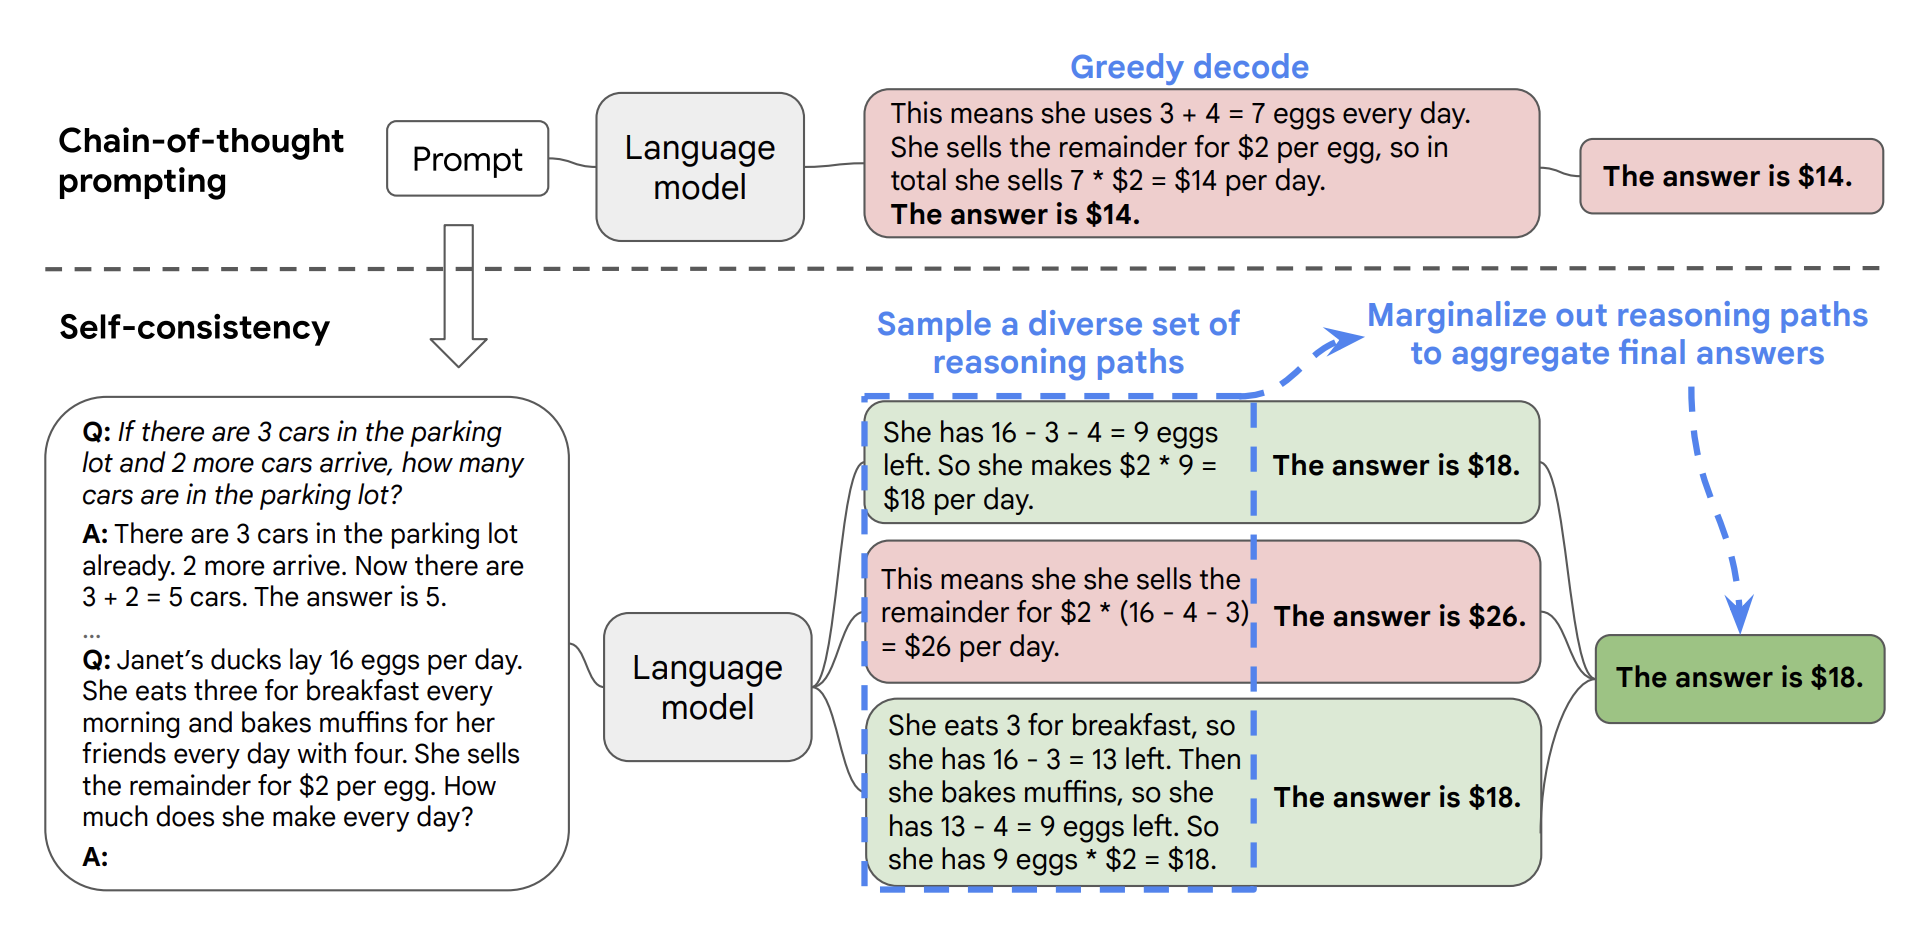

In [18]:
class SelfConsistencyState(TypedDict, total=False):
    question: str
    context: str
    reasoning_paths: List[str]
    answers: List[str]
    consistency_analysis: str
    final_answer: str
    num_paths: int

SELF_CONSISTENCY_PROMPT = PromptTemplate.from_template("""
Answer the following question using clear reasoning. Use a different approach each time.

Context:
{context}

Question: {question}

Reasoning path {path_number}:
Think about this question from a different angle and provide your reasoning and answer.

Response:""")

CONSISTENCY_ANALYSIS_PROMPT = PromptTemplate.from_template("""
Analyze the consistency of multiple reasoning paths and answers for the same question.

Question: {question}

Reasoning paths and answers:
{paths_and_answers}

Instructions:
1. Compare the different answers
2. Identify common themes and differences
3. Determine which answer is most consistent and well-reasoned
4. Provide a final consolidated answer

Analysis and Final Answer:""")

def self_consistency_generate_node(state: SelfConsistencyState):
    """Generate multiple reasoning paths"""
    question = state["question"]
    context = state["context"]
    num_paths = state.get("num_paths", 3)

    sc_chain = LLMChain(
        llm=llm,
        prompt=SELF_CONSISTENCY_PROMPT,
        output_key="response"
    )

    reasoning_paths = []
    answers = []

    for i in range(num_paths):
        result = sc_chain.run(
            context=context,
            question=question,
            path_number=i + 1
        )
        reasoning_paths.append(result)
        # Extract answer (simple heuristic - last few sentences)
        sentences = result.split('.')
        answer = '. '.join(sentences[-2:]) if len(sentences) > 1 else result
        answers.append(answer.strip())

    return {
        **state,
        "reasoning_paths": reasoning_paths,
        "answers": answers
    }

def self_consistency_analysis_node(state: SelfConsistencyState):
    """Analyze consistency and generate final answer"""
    question = state["question"]
    reasoning_paths = state["reasoning_paths"]
    answers = state["answers"]

    # Combine paths and answers
    paths_and_answers = []
    for i, (path, answer) in enumerate(zip(reasoning_paths, answers)):
        paths_and_answers.append(f"Path {i+1}:\n{path}\nAnswer {i+1}: {answer}\n")

    paths_and_answers_str = "\n".join(paths_and_answers)

    analysis_chain = LLMChain(
        llm=llm,
        prompt=CONSISTENCY_ANALYSIS_PROMPT,
        output_key="analysis"
    )

    analysis = analysis_chain.run(
        question=question,
        paths_and_answers=paths_and_answers_str
    )

    return {
        **state,
        "consistency_analysis": analysis,
        "final_answer": analysis
    }

def create_self_consistency_workflow():
    """Create Self-Consistency workflow"""
    workflow = StateGraph(SelfConsistencyState)
    workflow.add_node("sc_generate", self_consistency_generate_node)
    workflow.add_node("sc_analysis", self_consistency_analysis_node)

    workflow.set_entry_point("sc_generate")
    workflow.add_edge("sc_generate", "sc_analysis")
    workflow.add_edge("sc_analysis", END)

    return workflow.compile()

In [19]:
def run_advanced_reasoning_methods(question: str, pdf_path: str):
    """
    Run all four advanced reasoning methods on the given question and document.

    Args:
        question: The question to answer
        pdf_path: Path to the PDF document
    """

    # Process document
    print("Processing document...")
    document_context = doc_processor.process_pdf(pdf_path)
    retrieved_docs = doc_processor.retrieve_docs(question, k=3)
    context = "\n\n".join(retrieved_docs)

    results = {}

    # 4. Self-Consistency
    print("\n" + "="*50)
    print("4. SELF-CONSISTENCY REASONING")
    print("="*50)

    sc_workflow = create_self_consistency_workflow()
    sc_state = {
        "question": question,
        "context": context,
        "num_paths": 3
    }
    sc_result = sc_workflow.invoke(sc_state)
    results["self_consistency"] = sc_result["final_answer"]
    print(sc_result["final_answer"])

    return results

question = "Explain Usaha pemanfaatan dan pemungutan di hutan lindung"
pdf_path = "ruu1.pdf"
results = run_advanced_reasoning_methods(question, pdf_path)

Processing document...

4. SELF-CONSISTENCY REASONING
Let's analyze the consistency of the three reasoning paths and answers.

**1. Comparison of Answers:**

*   **Common Themes:** All three paths correctly identify the core purpose of a *hutan lindung* (protected forest) as *protection* of its ecological functions, biodiversity, and environmental stability. They all agree that *usaha pemanfaatan* (utilization efforts) and *pemungutan* (collection/extraction) are *highly restricted* and must be consistent with this protective function. They all mention NTFP collection, ecotourism, and research as potentially permissible activities, but only under strict conditions. They all explicitly prohibit large-scale logging, mining, and agricultural conversion.
*   **Differences:** The main differences lie in the emphasis and level of detail.
    *   Path 1 is the most general, focusing on the overall principle of preservation over exploitation.
    *   Path 2 emphasizes *minimal intervention* an